## 2.3 
Show how many genes would be deemed technologically infeasible? 

In [1]:
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RES_DIR = Path("/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/results/spapros_smk_res_bm")
RES_DIR_PROBE_DESIGN = Path("/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/results/probe_design")

SELECTION_BATCHS = ["batch_bm_1.1","batch_bm_1.2","batch_bm_1.3"]

In [3]:
datasets = ["Madissoon2019_w_cts", "Litvinukova2020_w_cts"]

In [4]:
def load_probe_design_df(dataset):
    """"""
    # Get genes passing contraints
    pattern = lambda dataset: f'{RES_DIR_PROBE_DESIGN}/output_{dataset}/*/gene_annotations.csv'
    files = glob.glob(pattern(dataset))
    for i,file in enumerate(files):
        #print(file)
        if i == 0:
            df = pd.read_csv(file,index_col=0)
        else:
            df_ = pd.read_csv(file,index_col=0)
            df["pass_constraints"] = df["pass_constraints"] | df_["pass_constraints"]
        #display(df.sum())
    
    # Get genes not in annotation
    pattern2 = lambda dataset: f'{RES_DIR_PROBE_DESIGN}/output_{dataset}/*/regions_with_insufficient_oligos.txt'
    files = glob.glob(pattern2(dataset))
    df["not_in_annotation"] = False
    for i,file in enumerate(files):
        #print(file)
        df_ = pd.read_csv(file,sep="\t",index_col=0)
        #display(df_)
        if len(df_) > 0:
            genes_not_in_ann = df_.loc[df_["Pipeline step"] == "Not in Annotation"].index.tolist()
            df.loc[genes_not_in_ann,"not_in_annotation"] = True
        #display(df.sum())
    
    df = df[["pass_constraints","not_in_annotation","highly_variable"]]

    return df

In [5]:
df = load_probe_design_df(datasets[0])

In [6]:
df.sum()

pass_constraints     5046
not_in_annotation    2052
highly_variable      7999
dtype: int64

In [7]:
# check that Lit and Mad shared genes have the same "pass_constraint" info
df_Mad = load_probe_design_df(datasets[0])
df_Lit = load_probe_design_df(datasets[1])

df_Mad = df_Mad.loc[df_Mad['highly_variable']]
df_Lit = df_Lit.loc[df_Lit['highly_variable']]

filt = df_Mad.loc[df_Mad.index.isin(df_Lit.index)].index.tolist()
assert (df_Lit.loc[filt,"pass_constraints"] == df_Mad.loc[filt,"pass_constraints"]).all()

### Generate statistics based on bootstrapping selections

In [17]:
df_sel = pd.read_csv(RES_DIR / "selection_overview.csv",index_col=0)

In [18]:
def get_proportions_of_genes_with_probes(dataset, df_sel=df_sel):
    """"""

    df = load_probe_design_df(dataset)
    df = df.loc[df['highly_variable']]
    
    # Load selections
    df_sel_subset = df_sel.loc[df_sel["batch"].isin(SELECTION_BATCHS) & (df_sel["dataset"] == dataset)]
    
    indices = []
    selection_masks = []
    
    for idx,row in df_sel_subset.iterrows():
        f = row["file_names"]
        df_selection = pd.read_csv(RES_DIR / f, index_col=0)
        indices.append(idx)
        selection_masks.append(df_selection.loc[df.index,df_selection.columns[0]].values.copy())
    
    df = pd.concat([df,pd.DataFrame(index=df.index, columns=indices, data=np.array(selection_masks).T)], axis=1)
    
    # Get overlaps
    df_overlaps = pd.DataFrame(
        index=indices,
        data = {
            "method" : df_sel_subset.loc[indices,"method"].values,
            "n" : df_sel_subset.loc[indices,"n"].values,
            "dataset" : dataset,
            "prop genes with probes" : 0.0
        }
    )
    
    df_ = df[~df["not_in_annotation"]].copy()
    for idx in indices:
        n_genes = df_[idx].sum()
        n_genes_with_probes = df_.loc[df_[idx],"pass_constraints"].sum()
        df_overlaps.loc[idx,"prop genes with probes"] = n_genes_with_probes/n_genes

    # Spapros end to end selection only selects genes that have probes. 
    # (in the loaded dataframe we only ran spapros gene panel selection with out probe design constraint, 
    # i.e. ot end to end, therefore we set it manually)
    df_overlaps = df_overlaps.loc[df_overlaps["method"] != "spaproscto"] 
    df_overlaps.loc[(df_overlaps["method"] == "spapros"), "prop genes with probes"] = 1

    return df_overlaps


In [19]:
df = pd.concat([get_proportions_of_genes_with_probes(dataset) for dataset in datasets])

dataset_to_str = {"Madissoon2019_w_cts" : "lung", "Litvinukova2020_w_cts" : "heart"}
df["dataset (n genes)"] = df.apply(lambda row: dataset_to_str[row["dataset"]] + f" ({row['n']})", axis=1)

In [ ]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 250
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/icb/louis.kuemmerle/miniconda3/envs/g1_rev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2229341/1396442557.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")


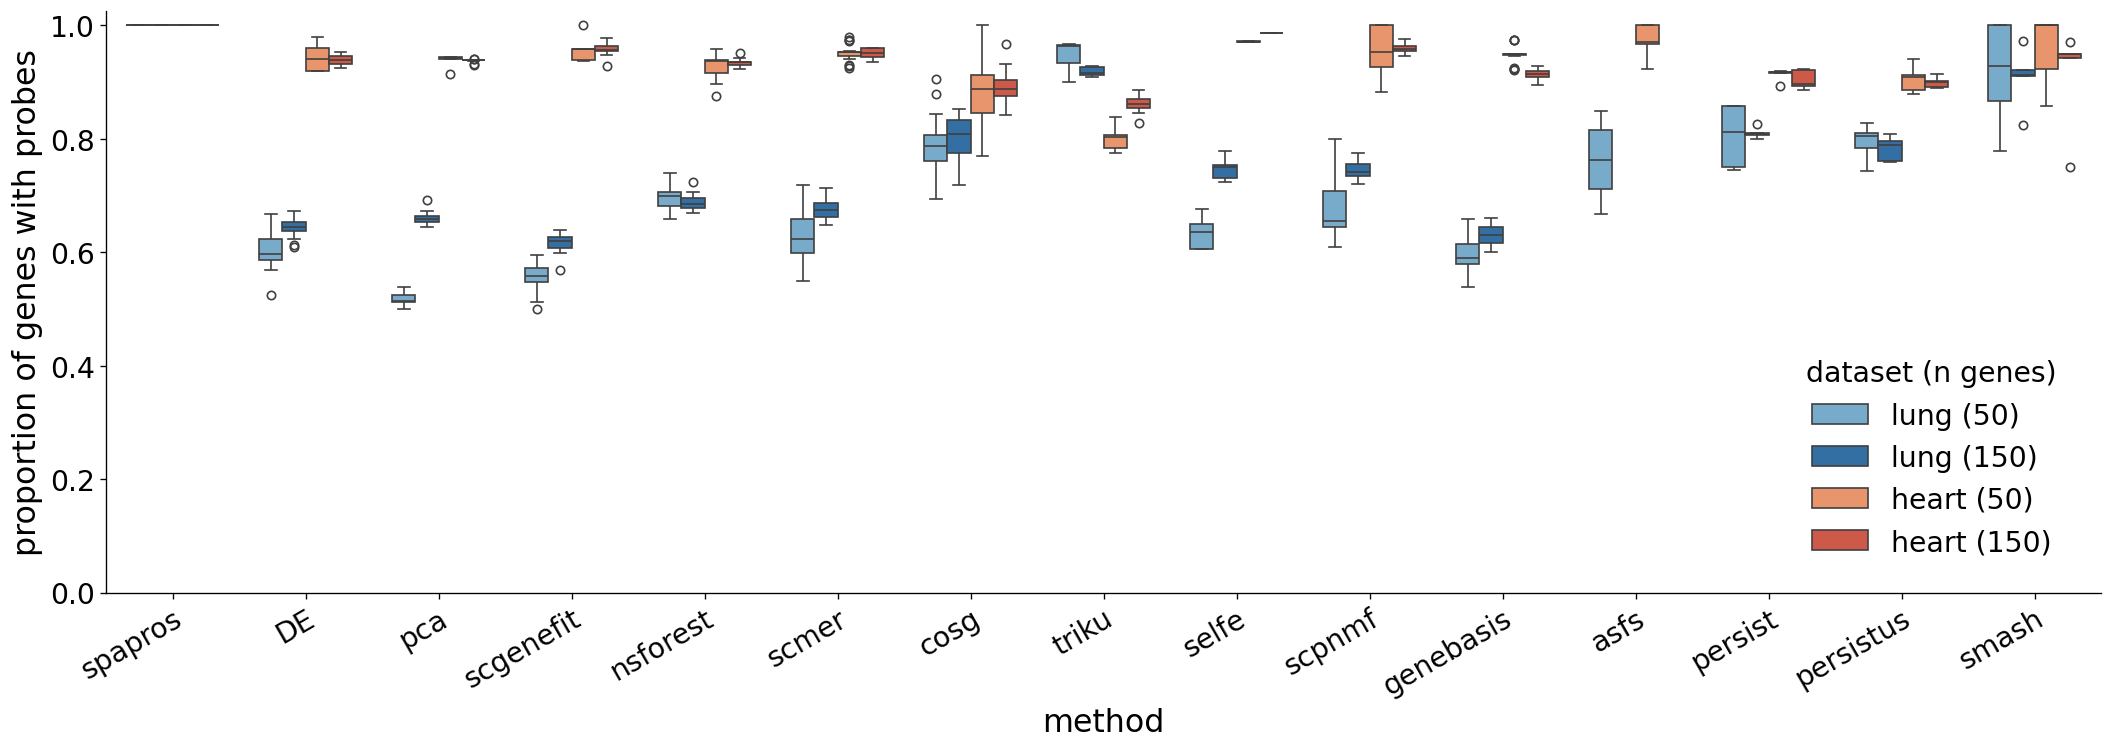

In [12]:
cp = sns.catplot(
    data=df, x="method", y="prop genes with probes", hue="dataset (n genes)", 
    kind="box", height=6, aspect=18/6, width=0.7,
    palette = {"lung (50)":"#6baed6" ,"lung (150)":"#2171b5" ,"heart (50)":"#fc8d59" ,"heart (150)":"#e34a33"}
)
sns.move_legend(cp, "lower right", bbox_to_anchor=(0.87, 0.165)) #, title='Species')
plt.ylim([0,None])
plt.ylabel("proportion of genes with probes")
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
plt.gcf().savefig("./figures/2_3_prop_genes_with_probes.pdf", bbox_inches = "tight", transparent=True)
plt.show()

In [13]:
sns.__version__

'0.13.1'

# Performance comparisons
Compare performances of gene sets with (Spapros) and without (other methods) probe design constraints.

In [20]:
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
RES_DIR = Path("/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/results/spapros_smk_res_bm_probes")

In [22]:
# Read selection overview table
df_sele = pd.read_csv(RES_DIR / "selection_overview.csv", index_col=0)
df_sele = df_sele.loc[df_sele["batch"].isin(SELECTION_BATCHS+["batch_bm_2"])]
df_sele = df_sele.set_index("selection_name")

# Read evaluation overview table
df_eval = pd.read_csv(RES_DIR / "evaluation_overview.csv", index_col=0)

# Get metrics file
df_eval_tmp = df_eval.loc[df_eval["eval_batch"]=="eval_batch_bm_1"]
eval_summary_file = df_eval_tmp["eval_summary_file"].unique()[0]
df = pd.read_csv(RES_DIR / eval_summary_file, index_col=0)

# Add aggregated scores
df["ct score"] = (df['forest_clfs accuracy'] + df['forest_clfs perct acc > 0.8']) / 2
df["var score"] = (df['knn_overlap mean_overlap_AUC'] + df['cluster_similarity nmi_5_20'] + df['cluster_similarity nmi_21_60']) / 3
df["score"] = (df["ct score"] + df["var score"]) / 2

# Add method info
df["method"] = df_sele.loc[df.index,"method"]

# Sort according mean performance
method_order = df.groupby("method").mean()["score"].sort_values(ascending=False).index.tolist()

In [23]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 250
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/icb/louis.kuemmerle/miniconda3/envs/g1_rev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


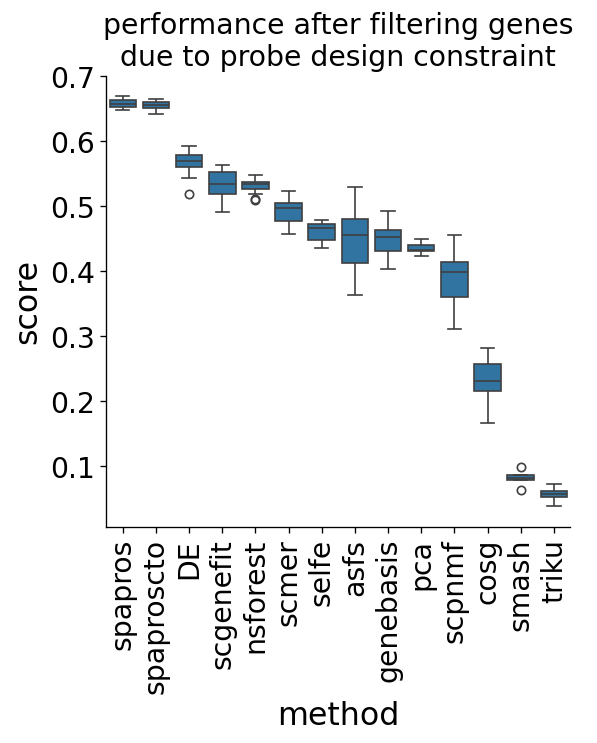

In [24]:
cp = sns.catplot(
    data=df, x="method", y="score", order=method_order, #, hue="dataset (n genes)", 
    kind="box"#, height=6, aspect=18/6, width=0.7,
    #palette = {"lung (50)":"#6baed6" ,"lung (150)":"#2171b5" ,"heart (50)":"#fc8d59" ,"heart (150)":"#e34a33"}
)
#cp.set_xticklabels(rotation=30, )
#plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("performance after filtering genes\ndue to probe design constraint")
plt.gca().tick_params(axis='x', rotation=90)
plt.gcf().savefig("figures/2_3_performance_after_probe_filter.pdf", bbox_inches = "tight", transparent=True)